# House prices analysis for Kaggle competition

by
Greg Pelletier

The Kaggle House Price Competition is a challenge that encourages the application of advanced regression techniques and creative feature engineering to build models that can accurately predict house prices. Participants explore the data, create and engineer features, build models, and submit predictions. The competition is an excellent starting point for practical experience in data science and machine learning. The following link is the official Web page for the kaggle house price competition:

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

In this notebook I analyze the kaggle house price data using a Stacking Regression method available at this link to the stepAIC module:

https://github.com/gjpelletier/stepAIC

### Stacking Regression

The **stacking** function in the stepAIC module provides output of a fitted regression model and summary statistics using the sklearn StackingRegressor function for ensemble modeling with any combination of sklearn base regressors which can be turned 'on' or 'off' with the following optional keyword arguments:

- Lasso= 'on' (default) or 'off'        uses LassoCV
- Ridge= 'on' (default) or 'off'        uses RidgeCV
- ElasticNet= 'on' (default) or 'off'   uses ElasticNetCV
- SGD= 'on' (default) or 'off'          uses SGDRegressor
- KNN= 'on' (default) or 'off'          uses KNeighborsRegressor
- SVR= 'on' (default) or 'off'          uses SVR(kernel='rbf')
- MLP= 'on' or 'off' (default)          uses MLPRegressor
- XGB= 'on' (default) or 'off'          uses GradientBoostingRegressor
- DecisionTree= 'on' (default) or 'off' uses DecisionTreeRegressor
- RandomForest= 'on' (default) or 'off' uses RandomForestRegressor

Stacking regression is an **ensemble** machine learning technique that improves predictive accuracy by combining multiple base regression models. Instead of selecting a single best model, stacking leverages multiple models to generate a more robust final prediction.

**How Stacking Regression Works**

Base Regressors (Level 0 Models):  
- Several regression models (e.g., Lasso, Ridge, Elastic, DecisionTree, RandomForest, etc.) are trained independently on the dataset.
- Each model learns different aspects of the data.

Meta-Model (Level 1 Model):  
- A separate model (linear regression) is trained to **learn from the outputs of base models**.
- It assigns strength weights to each base model’s predictions, determining which models contribute the most to final accuracy.

Final Prediction: 
- The meta-model makes a final prediction based on the base models' combined outputs.

#### Kaggle competition leaderboard score using this notebook

The analysis documented in this notebook resulted in a leaderboard score of 0.12102 (rank 343). Any score between 0.1 to 0.15 is considered to be a "good" score.

# Data cleaning, feature transformations, final features

The data cleaning, feature transformations, feature engineering, and final features in this section were adapted from the following publicly posted python code:

https://www.kaggle.com/code/itslek/blend-stack-lr-gb-0-10649-house-prices-v57

In [37]:
import numpy as np  # linear algebra
import pandas as pd  #
from datetime import datetime

from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

# from mlxtend.regressor import StackingCVRegressor
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor

import os
import scipy.stats as stats
import matplotlib.pyplot as plt

In [20]:
# read train data into dataframe df_train
train_path = "/mnt/c/z/kaggle/house_prices/data/train.csv"
train = pd.read_csv(train_path)
print("Full train dataset shape is {}".format(df_train.shape))
# print(df_train.head())

# read test data into dataframe df_test
test_path = "/mnt/c/z/kaggle/house_prices/data/test.csv"
test = pd.read_csv(test_path)
print("Full test dataset shape is {}".format(df_test.shape))
# print(df_test.head())

Full train dataset shape is (1460, 81)
Full test dataset shape is (1459, 80)


In [21]:
train_ID = train['Id']
test_ID = test['Id']
# Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

# Deleting outliers
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)

# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train.SalePrice.reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

In [22]:
features = pd.concat([train_features, test_features]).reset_index(drop=True)
print(features.shape)
# Some of the non-numeric predictors are stored as numbers; we convert them into strings 
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

features['Functional'] = features['Functional'].fillna('Typ')
features['Electrical'] = features['Electrical'].fillna("SBrkr")
features['KitchenQual'] = features['KitchenQual'].fillna("TA")
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

features["PoolQC"] = features["PoolQC"].fillna("None")

(2917, 79)


In [23]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)

features.update(features[objects].fillna('None'))

features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))


In [24]:
# Filling in the rest of the NA's

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)

In [25]:
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    # features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))
    features[i] = np.log1p(features[i])

features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

# simplified features
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [26]:
print(features.shape)
final_features = pd.get_dummies(features).reset_index(drop=True)
print(final_features.shape)

(2917, 86)
(2917, 333)


In [27]:
X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(X):, :]

print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

X (1458, 333) y (1458,) X_sub (1459, 333)


In [28]:
# Note: I can't find documentation of how these outliers were discovered
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

In [29]:
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
overfit.append('MSZoning_C (all)')

In [30]:
X = X.drop(overfit, axis=1).copy()
X_sub = X_sub.drop(overfit, axis=1).copy()

print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

X (1453, 331) y (1453,) X_sub (1459, 331)


## Stacking regression

Next we will use the **stacking** function from the stepAIC module (https://github.com/gjpelletier/stepAIC) to perform the regression analysis. 

The **stacking** function in the stepAIC module provides output of a fitted regression model and summary statistics using the sklearn StackingRegressor function for ensemble modeling with any combination of sklearn base regressors which can be turned 'on' or 'off' with the following optional keyword arguments:

- Lasso= 'on' (default) or 'off'        uses LassoCV
- Ridge= 'on' (default) or 'off'        uses RidgeCV
- ElasticNet= 'on' (default) or 'off'   uses ElasticNetCV
- SGD= 'on' (default) or 'off'          uses SGDRegressor
- KNN= 'on' (default) or 'off'          uses KNeighborsRegressor
- SVR= 'on' (default) or 'off'          uses SVR(kernel='rbf')
- MLP= 'on' or 'off' (default)          uses MLPRegressor
- XGB= 'on' (default) or 'off'          uses GradientBoostingRegressor
- DecisionTree= 'on' (default) or 'off' uses DecisionTreeRegressor
- RandomForest= 'on' (default) or 'off' uses RandomForestRegressor

Stacking regression is an **ensemble** machine learning technique that improves predictive accuracy by combining multiple base regression models. Instead of selecting a single best model, stacking leverages multiple models to generate a more robust final prediction.

Note that the **stacking** function standardizes the X inputs by default. This can be turned off by using the optional keyword argument standardize='off' if you have already standardized X. 

Fitting StackingRegressor models, please wait ...


StackingRegressor statistics of fitted ensemble model in model_outputs['stats']:


| Statistic          |   StackingRegressor |
|:-------------------|--------------------:|
| r-squared          |         0.952931    |
| adjusted r-squared |         0.939033    |
| n_samples          |      1453           |
| df residuals       |      1122           |
| df model           |       330           |
| F-statistic        |        68.8341      |
| Prob (F-statistic) |         1.11022e-16 |
| RMSE               |         0.0860935   |
| Log-Likelihood     |      1501.51        |
| AIC                |     -2341.01        |
| BIC                |      -592.873       |


Strength coefficients of base_regressors in model_outputs['strength']:


- positive intercept suggests base models under-predict target
- negative intercept suggests base models over-predict target
- positive coefficients have high importance
- coefficients near zero have low i

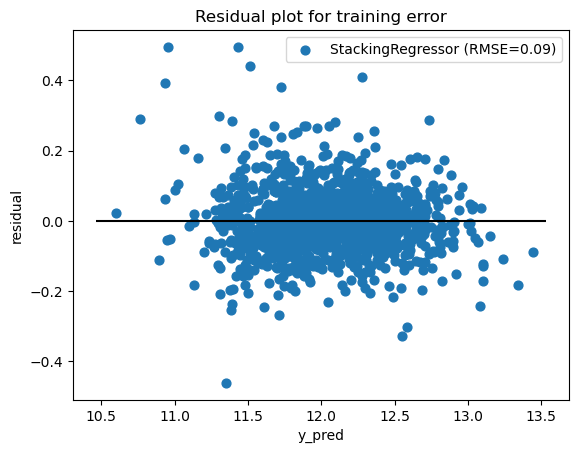

In [31]:
from stepAIC import stacking
model_object, model_output = stacking(X, y)

# Predictions for submission

In [32]:
# Standardize X_sub with the same scaler that was used for X in stacking
scaler = model_output['scaler']
X_sub_scaled = scaler.transform(X_sub)
# Convert scaled arrays into pandas dataframes with same column names as X
X_sub_scaled = pd.DataFrame(X_sub_scaled, columns=X_sub.columns)
# Copy index from unscaled to scaled dataframes
X_sub_scaled.index = X_sub.index
# print(X_sub_scaled.shape)
# X_sub_scaled

In [33]:
# predicted y using the standardized X_Sub
y_pred = model_object.predict(X_sub_scaled)

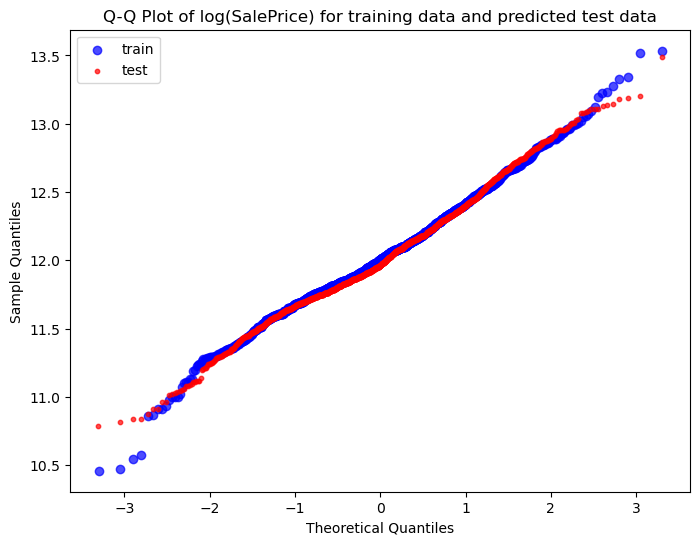

In [38]:
# QQ plot to compare the log-transformed y and y_pred

data1 = y        # training data
data2 = y_pred   # predicted from test X_sub

# Generate Q-Q plot data for both datasets
qq1 = stats.probplot(data1, dist="norm")
qq2 = stats.probplot(data2, dist="norm")

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the first dataset
plt.scatter(qq1[0][0], qq1[0][1], color='blue', label='train', alpha=0.7)

# Plot the second dataset
plt.scatter(qq2[0][0], qq2[0][1], color='red', label='test', alpha=0.7, s=10)

# Customize the plot
plt.title('Q-Q Plot of log(SalePrice) for training data and predicted test data')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.legend()
# plt.grid()

# Show the plot
plt.show()

In [44]:
# read test data again to retrieve the test Id
test_path = "/mnt/c/z/kaggle/house_prices/data/test.csv"
test2 = pd.read_csv(test_path)
# print("Full test dataset shape is {}".format(df_test.shape))
# print(test2.head())

In [43]:
# Make the csv file to submit the predictions to kaggle 
submission = pd.DataFrame(
    {
        "Id": test2['Id'],
        "SalePrice": np.expm1(y_pred)
    }
    )
submission
submission.to_csv('submission_StackingRegressor_v31.csv', index=False) 